# Preprocessing

In [1]:
api_key = ""
channel_id = ""

In [2]:
from googleapiclient.discovery import build
youtube = build("youtube", "v3", developerKey=api_key)

In [3]:
def get_channel_videos(channel_id):
    res = youtube.channels().list(id=channel_id,
                                 part="contentDetails").execute()
    playlist_id = res["items"][0]["contentDetails"]["relatedPlaylists"]["uploads"]
    
    videos = []
    next_page_token = None
    
    while 1:
        res = youtube.playlistItems().list(playlistId=playlist_id,
                                          part="snippet",
                                          maxResults=50,
                                          pageToken=next_page_token).execute()
        videos += res["items"]
        next_page_token = res.get("nextPageToken")
        
        if next_page_token is None:
            break
    
    return videos

In [4]:
videos = get_channel_videos(channel_id)

In [5]:
res = youtube.videos().list(id=videos[0]["snippet"]["resourceId"]["videoId"],
                           part="statistics").execute()

In [6]:
video_ids = list(map(lambda x:x['snippet']['resourceId']['videoId'], videos))

In [7]:
def get_videos_stats(video_ids):
    stats = []
    for i in range(0, len(video_ids), 50):
        res = youtube.videos().list(id=','.join(video_ids[i:i+50]),
                                   part='statistics').execute()
        stats += res['items']
    return stats

In [8]:
stats = get_videos_stats(video_ids)

# List Before Dataframe

In [22]:
publishedAt = []
title = []
viewCount = []
likeCount = []
dislikeCount = []
commentCount = []

for i in range(len(videos)):
    publishedAt.append(videos[i]['snippet']['publishedAt'])
    title.append(videos[i]['snippet']['title'])
    viewCount.append(stats[i]['statistics']['viewCount'])
    likeCount.append(stats[i]['statistics']['likeCount'])
    dislikeCount.append(stats[i]['statistics']['dislikeCount'])
    commentCount.append(stats[i]['statistics']['commentCount'])

# Dataframe
공개일, 제목, 조회수, 좋아요수, 싫어요수, 댓글수

In [23]:
import pandas as pd
names = ['publishedAt', 'title', 'viewCount', 'likeCount', 'dislikeCount', 'commentCount']
df = pd.DataFrame(data=list(zip(publishedAt, title, viewCount, likeCount, dislikeCount, commentCount)),
                 columns=names)

# int로 변환

In [24]:
df['viewCount'] = df['viewCount'].astype(int)
df['likeCount'] = df['likeCount'].astype(int)
df['dislikeCount'] = df['dislikeCount'].astype(int)
df['commentCount'] = df['commentCount'].astype(int)

# 라이브 영상 Drop하기

In [25]:
import re
def reg_live(word):
    if re.compile('라이브').search(word):
        return True
    else:
        return False

In [26]:
df['live'] = df['title'].apply(reg_live)

In [27]:
df = df.loc[(df['live'] == False)]
len(df)

2582

# 제목에 '에이치엘비'가 없다면 Drop하기

In [28]:
df['에이치엘비'] = df['title'].str.contains('에이치엘비')
df = df.loc[(df['에이치엘비'] == True)]
len(df)

1437

# 제목에 '에이치엘비생명과학'이 있다면 Drop하기

In [29]:
df['에이치엘비생명과학'] = df['title'].str.contains('에이치엘비생명과학')
df = df.loc[df['에이치엘비생명과학'] == False]
len(df)

1400

# 제목에 '에이치엘비제약'이 있다면 Drop하기

In [30]:
df['에이치엘비제약'] = df['title'].str.contains('에이치엘비제약')
df = df.loc[(df['에이치엘비제약'] == False)]
len(df)

1372

# 과거 절반 데이터 Drop하기

In [31]:
df = df[:int(len(df)/2)]
len(df)

686

# 최근 데이터 Drop하기
공개된지 몇 시간 되지 않아 아직 조회수가 채워지지 않았기 때문에 같은 기준으로 분석할 수 없다.

In [32]:
df = df[5:]
len(df)

681

# 필요한 column 빼고 전부 Drop하기

In [33]:
df = df[['title', 'viewCount']]

# 전처리 완료

In [34]:
df.head()

,title,viewCount
5,에이치엘비 허위공시 워딩이 자꾸 나오는데 진짜 허위공시는 이런 것이다!!,6639
6,에이치엘비 추가 무상증자 가능성과 엘생의 지분법 평가내역!!,16879
7,에이치엘비와 어딘가 순서가 거꾸로된 TS인베스트먼트의 무증후 대주주매도!,7483
8,에이치엘비 계열회사 넥스트사이언스 임원의 스톡옵션 단타 시도?!,5989
9,에이치엘비 4월 미국암학회는 몸 풀기고 6월 ASCO는 본게임이다!,9771


# 분석 시작 

# 글자수가 40자 이하면 조회수가 높은가

In [36]:
df['length'] = df['title'].apply(len) <= 40

In [37]:
df.head()

,title,viewCount,length
5,에이치엘비 허위공시 워딩이 자꾸 나오는데 진짜 허위공시는 이런 것이다!!,6639,True
6,에이치엘비 추가 무상증자 가능성과 엘생의 지분법 평가내역!!,16879,True
7,에이치엘비와 어딘가 순서가 거꾸로된 TS인베스트먼트의 무증후 대주주매도!,7483,True
8,에이치엘비 계열회사 넥스트사이언스 임원의 스톡옵션 단타 시도?!,5989,True
9,에이치엘비 4월 미국암학회는 몸 풀기고 6월 ASCO는 본게임이다!,9771,True


# 각 Sample Size 구하기

In [38]:
df.groupby('length').viewCount.size()

length
False    386
True     295
Name: viewCount, dtype: int64

# 각 조회수 평균 구하기

In [39]:
df.groupby('length').viewCount.mean()

length
False    7132.865285
True     8225.355932
Name: viewCount, dtype: float64

# t-test하기

In [41]:
from scipy.stats import ttest_ind
short_length = df.loc[df['length'] == True].viewCount
long_length = df.loc[df['length'] == False].viewCount

In [42]:
ttest_ind(short_length, long_length)

Ttest_indResult(statistic=2.8052501726304766, pvalue=0.005171634058537867)

# Barchart

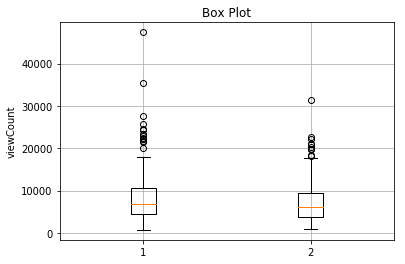

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.boxplot([short_length, long_length])
plt.xlabel('')
plt.ylabel('viewCount')
plt.title('Box Plot')
plt.grid()
plt.show()

# Results
글자수가 짧은(40자 이하) 영상의 조회수 평균은 8,225회  
글자수가 긴  (40자 초과) 영상의 조회수 평균은 7,132회  
(p=0.005)

# Conclusion
제목 글자수를 40자 이하로 제한한다.